# 04 – Preprocessing & Feature Engineering
### Car Price Prediction Using Machine Learning
Group Assignment 02 - CCS3012 - Data Analytics  
Submission Date: 16th September 2025

---

### **Group 11**
-  **FC211034 - N.D. Samararathne Kodikara**
-  **FC211013 - N.W.V. Tharindu Pabasara**
-  **FC211025 - W.M.M.C.B. Wijesundara**



---


### **Supervisor**
**Ms. Dilmi Praveena**  
*Faculty of Computing*  
*University of Sri Jayewardenepura*

---


## 📌 Objectives

This notebook builds upon the cleaned dataset produced in **Notebook 01 — Data Exploration & Cleaning**.
The focus here is to prepare the dataset for modeling by performing outlier detection, handling, and feature engineering, including:

---

- **Outlier detection & handling**: We have identified extreme and unrealistic values some numerical features such as price, mileage, levy, engine_volume and here we will decide whether to remove or retain them.

- **Feature engineering**: Create new features to better capture information.

- **Data consistency & cleaning**: Ensure all engineered features are correctly formatted, handle missing or zero values appropriately, and reduce noise in the dataset..

---

### 📂 Input  
- `clean_data.csv` saved in `Data/processed/`  
---

### 📊 Dataset Overview
**Dataset:** Car price dataset cleaned.  
**columns include**:   
- `id`, `price` (target variable),  `levy`,  `manufacturer`,  `model`,  `prod_year`,  `category`,  `leather_interior`,  `fuel_type`, `engine_volume`,  `mileage`,  `cylinders`,  `gear_box_type`,  `drive_wheels`,  `doors`,  `wheel`, `color`,  `airbags`,  `turbo` (derived in Notebook 01)


> **Dataset stats:** 19,237 rows × 19 features | Target variable: `price` | Problem type: Regression


# Setup & imports

In [263]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Statistical functions
from scipy import stats

from sklearn.model_selection import train_test_split

from prettytable import PrettyTable 

In [264]:
df = pd.read_csv("./Data/processed/clean_data.csv")


In [265]:
# Function to normalize text
def normalize_text(s):
    if pd.isna(s):
        return s
    s = str(s).strip().lower()        # lowercase and strip spaces
    s = s.replace(' ', '-')           # replace spaces with '-'
    return s

# Apply to all object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(normalize_text)

# Quick check
df.head()

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
0,45654403,13328,1399.0,lexus,rx-450,2010,jeep,yes,hybrid,3.5,186005,6,automatic,4x4,04-may,left-wheel,silver,12,False
1,44731507,16621,1018.0,chevrolet,equinox,2011,jeep,no,petrol,3.0,192000,6,tiptronic,4x4,04-may,left-wheel,black,8,False
2,45774419,8467,0.0,honda,fit,2006,hatchback,no,petrol,1.3,200000,4,variator,front,04-may,right-hand-drive,black,2,False
3,45769185,3607,862.0,ford,escape,2011,jeep,yes,hybrid,2.5,168966,4,automatic,4x4,04-may,left-wheel,white,0,False
4,45809263,11726,446.0,honda,fit,2014,hatchback,yes,petrol,1.3,91901,4,automatic,front,04-may,left-wheel,silver,4,False


In [266]:
# Prints the name of each column in the dataset, the number of non-null values it contains, and its data type.
def df_info(df):
    table = PrettyTable()
    table.field_names = ["Column", "Non-Null Count", "Dtype"]

    for col in df.columns:
        non_null_count = df[col].count()
        dtype = df[col].dtype
        table.add_row([col, non_null_count, dtype])

    print(table)

df_info(df)

+------------------+----------------+---------+
|      Column      | Non-Null Count |  Dtype  |
+------------------+----------------+---------+
|        id        |     15697      |  int64  |
|      price       |     15697      |  int64  |
|       levy       |     15697      | float64 |
|   manufacturer   |     15697      |  object |
|      model       |     15697      |  object |
|    prod_year     |     15697      |  int64  |
|     category     |     15697      |  object |
| leather_interior |     15697      |  object |
|    fuel_type     |     15697      |  object |
|  engine_volume   |     15697      | float64 |
|     mileage      |     15697      |  int64  |
|    cylinders     |     15697      |  int64  |
|  gear_box_type   |     15697      |  object |
|   drive_wheels   |     15697      |  object |
|      doors       |     15697      |  object |
|      wheel       |     15697      |  object |
|      color       |     15697      |  object |
|     airbags      |     15697      |  i

💡 **Observations:**  
- The data set appears unchanged and matches the previously saved version.

Le't start...

# **Deterministic cleaning & derived column**
Doing before train/test split because cause no target leakage

## `doors` column

> 🧩 Standardize to two representations:
> - `doors_count` numeric: 2, 4, 6 (use 6 as proxy for >5)
> - `doors_cat` original categorical for interactions

In [267]:
def doors_to_count(s):
    if pd.isna(s): return np.nan
    s = str(s).lower()
    if '02' in s or '02-mar' in s: return 2
    if '04' in s or '04-may' in s: return 4
    if '>' in s or '>5' in s: return 6
    # fallback: try to extract first number
    import re
    m = re.search(r'\d+', s)  # fallback: extract first number in the string
    return int(m.group()) if m else np.nan

df['doors_count'] = df['doors'].apply(doors_to_count)
print(f"✅ created doors_count column.")
df['doors_count'].value_counts()


✅ created doors_count column.


doors_count
4    14835
2      738
6      124
Name: count, dtype: int64

In [268]:
# Mapping dictionary
doors_map = {
    '02-mar': '2-3',
    '04-may': '4-5',
    '>5': '>5'
}

# Apply mapping
df['doors_cat'] = df['doors'].map(doors_map).fillna(df['doors'])
print(f"✅ created doors_cat column.")
df['doors_cat'].value_counts()

✅ created doors_cat column.


doors_cat
4-5    14835
2-3      738
>5       124
Name: count, dtype: int64

## `Cylinders` column

> 🧩 grouping into buckets  
> 🧩 Ordinal encoding. start with `1`


In [269]:
def cylinder_group(x):
    if pd.isna(x): return np.nan
    if x <= 2: return '1-2'
    if 3 <= x <= 4: return '3-4'
    if 5 <= x <= 8: return '5-8'
    return '>8'

df['cylinder_group'] = df['cylinders'].apply(cylinder_group)
print(f"✅ created cylinder_group column.")
df['cylinder_group'].value_counts()


✅ created cylinder_group column.


cylinder_group
3-4    12372
5-8     3196
1-2       78
>8        51
Name: count, dtype: int64

In [270]:
# Define the order
cylinder_order = ['1-2', '3-4', '5-8', '>8']

# Map to ordinal numbers
df['cylinder_group_ord'] = df['cylinder_group'].map({k: i+1 for i, k in enumerate(cylinder_order)})

print(f"✅ created cylinder_group_ord column.\n")
print(df[['cylinder_group', 'cylinder_group_ord']].head())


✅ created cylinder_group_ord column.

  cylinder_group  cylinder_group_ord
0            5-8                   3
1            5-8                   3
2            3-4                   2
3            3-4                   2
4            3-4                   2


## `Airbags` column

> 🧩 Grouping ['0','1-2','3-4','5-8','>8']  
> 🧩 Ordinal Encoding. start with `0`

In [271]:
# Function to group airbags
def airbags_group(n):
    if pd.isna(n):  # handle missing values
        return np.nan
    if n == 0:
        return '0'
    if 1 <= n <= 2:
        return '1-2'
    if 3 <= n <= 4:
        return '3-4'
    if 5 <= n <= 8:
        return '5-8'
    return '>8'

# Apply to datset
df['airbags_group'] = df['airbags'].apply(airbags_group)
print(f"✅ created airbags_group column.")
df['airbags_group'].value_counts()


✅ created airbags_group column.


airbags_group
3-4    5141
>8     5019
5-8    3040
0      1378
1-2    1119
Name: count, dtype: int64

In [272]:
airbags_order = ['0', '1-2', '3-4', '5-8', '>8']  # define order

# ordinal encoding
df['airbags_group_ord'] = df['airbags_group'].map({k: i for i, k in enumerate(airbags_order)})

print(f"✅ created airbags_group_ord column.\n")
print(df[['airbags_group', 'airbags_group_ord']].head())


✅ created airbags_group_ord column.

  airbags_group  airbags_group_ord
0            >8                  4
1           5-8                  3
2           1-2                  1
3             0                  0
4           3-4                  2


## `Car Age` column

> 🧩 current_year - prod_year

In [273]:
import datetime

current_year = datetime.datetime.now().year  # get current year

df['car_age'] = current_year - df['prod_year']

print(f"✅ created car_age column.")
# check for negative or weird values
print(df['car_age'].describe())


✅ created car_age column.
count    15697.000000
mean        14.410015
std          5.697194
min          5.000000
25%         11.000000
50%         13.000000
75%         17.000000
max         45.000000
Name: car_age, dtype: float64


## `leather_interior` column

> 🧩 create `has_leather` binary : Directly captures the positive price effect of leather.

In [274]:
# Function map has_leather
def has_leather(x):
    if pd.isna(x):
        return 0 
    if str(x).strip().lower() in ['yes']:
        return 1
    return 0

# Apply to df
df['has_leather'] = df['leather_interior'].apply(has_leather)

print(f"✅ created has_leather column.\n")

# Quick check
print(df[['leather_interior', 'has_leather']].value_counts())


✅ created has_leather column.

leather_interior  has_leather
yes               1              10547
no                0               5150
Name: count, dtype: int64


## `fuel_type` column

> 🧩 Grouping: [petrol, diesel, hybrid, lpg] 

In [275]:
df['fuel_type'].value_counts()

fuel_type
petrol            8801
diesel            3206
hybrid            2424
lpg                714
cng                466
plug-in-hybrid      85
hydrogen             1
Name: count, dtype: int64

In [276]:
fuel_bins = {
    'petrol': 'petrol',
    'diesel': 'diesel',
    'hybrid': 'hybrid',
    'plug-in-hybrid': 'hybrid',
    'lpg': 'lpg',
    'cng': 'lpg',
    'hydrogen': 'lpg'
}

df['fuel_bin'] = df['fuel_type'].str.strip().str.lower().map(fuel_bins)

# Check counts

print(f"✅ created fuel_bin column.\n")
print(df['fuel_bin'].value_counts())


✅ created fuel_bin column.

fuel_bin
petrol    8801
diesel    3206
hybrid    2509
lpg       1181
Name: count, dtype: int64


## `color` column

> 🧩 create feature `is_common_color` : [black/white/silver/grey/blue/red]  


In [277]:
# Define common colors
common_colors = ['black', 'white', 'silver', 'grey', 'blue', 'red']

# Function to check if color is common
def is_common_color_func(color):
    if pd.isna(color):
        return 0
    return 1 if str(color).strip().lower() in common_colors else 0

# Apply to df
df['is_common_color'] = df['color'].apply(is_common_color_func)


print(f"✅ created is_common_color column.\n")

# Quick check
print(df[['color', 'is_common_color']].value_counts())


✅ created is_common_color column.

color          is_common_color
black          1                  3832
white          1                  3605
silver         1                  3146
grey           1                  1918
blue           1                  1245
red            1                   564
green          0                   286
orange         0                   204
carnelian-red  0                   177
brown          0                   171
golden         0                   142
beige          0                   132
sky-blue       0                   119
yellow         0                    92
purple         0                    39
pink           0                    25
Name: count, dtype: int64


## `category` column

> 🧩 Domain Mapping: map `categories` into `luxury`, `utility`, `family`.  
> 🧩 Create `category_simple` column.

In [278]:
# Normalize category strings: lowercase, replace spaces with dash, strip
df['category'] = df['category'].str.lower().str.strip().str.replace(' ', '-')


# define mappings
domain_map = {
    'sedan': 'car',
    'hatchback': 'car',
    'universal': 'car',
    'jeep': 'utility', 
    'pickup': 'utility',
    'goods-wagon': 'utility',
    'limousine': 'luxury',
    'cabriolet': 'luxury',
    'coupe': 'luxury',
    'minivan': 'family',
    'microbus': 'family'
}


# Apply mapping
df['domain'] = df['category'].str.strip().str.lower().map(domain_map)


print(f"✅ created domain column.\n")

# Quick check
print(df['domain'].value_counts())



✅ created domain column.

domain
car        9858
utility    4496
family      829
luxury      514
Name: count, dtype: int64


In [279]:
category_map = {
    # SUVs / off-road
    'jeep': 'suv',
    'suv': 'suv',
    'pickup': 'suv',
    'goods-wagon': 'suv',
    
    # cars
    'limousine': 'car',
    'cabriolet': 'car',
    'coupe': 'car',
    'sedan': 'car',
    'hatchback': 'car',
    'universal': 'car',
    
    # Family / vans
    'minivan': 'van',
    'microbus': 'van'
}

df['category_simple'] = df['category'].str.strip().str.lower().map(category_map)

print(f"✅ created category_simple column.\n")

# Quick check
print(df['category_simple'].value_counts())


✅ created category_simple column.

category_simple
car    10372
suv     4496
van      829
Name: count, dtype: int64


## `engine_volume` × `Turbo` columns

> 🧩 create `engine_turbo`column : `engine_volume` * `turbo_flag`

In [280]:
# Make sure these columns exist and are numeric
df['engine_volume'] = pd.to_numeric(df['engine_volume'], errors='coerce')


In [281]:
# Create the interaction feature
df['engine_turbo'] = df['engine_volume'] * df['turbo']

print(f"✅ created engine_turbo column.\n")

print(df[['engine_volume', 'turbo', 'engine_turbo']].tail())

✅ created engine_turbo column.

       engine_volume  turbo  engine_turbo
15692            1.8  False           0.0
15693            2.0   True           2.0
15694            2.4  False           0.0
15695            2.0  False           0.0
15696            2.4  False           0.0


## `doors_count` and `domain` columns

> 🧩 interactions between categorical variables `doors_count` and `domain`.

In [282]:
# create doors_domain feature
df['doors_domain'] = df['doors_count'].astype(str) + '_' + df['domain'].astype(str)

print(f"✅ created doors_domain column.\n")

# Quick check
print(df[['doors_count', 'domain', 'doors_domain']].value_counts().head(3))


✅ created doors_domain column.

doors_count  domain   doors_domain
4            car      4_car           9675
             utility  4_utility       4316
             family   4_family         696
Name: count, dtype: int64


# **Outlier Detection & Handling**

              price  price_capped     price_log
count  1.569700e+04  15697.000000  15697.000000
mean   2.028445e+04  18184.009110      9.238175
std    2.108237e+05  16422.361246      1.419014
min    1.000000e+00     40.000000      3.713572
25%    7.527000e+03   7527.000000      8.926385
50%    1.426900e+04  14269.000000      9.565915
75%    2.338900e+04  23389.000000     10.060064
max    2.630750e+07  89379.000000     11.400652


<Figure size 1200x500 with 0 Axes>

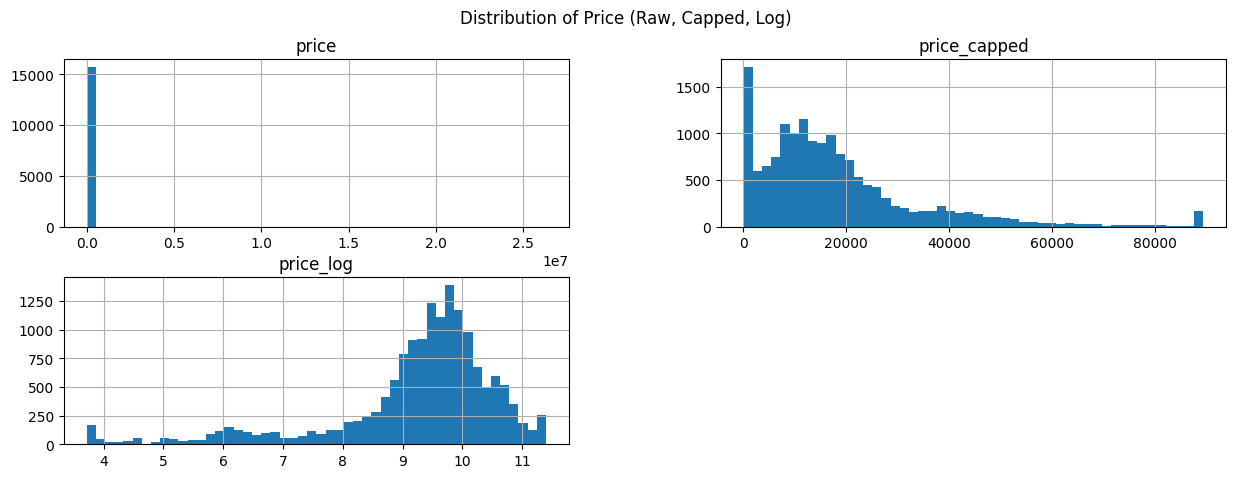

In [283]:
# Define numeric + target
numeric_cols = ['mileage', 'engine_volume', 'levy']
target_col = 'price'

# Outlier capping (1st and 99th percentiles)
for col in numeric_cols + [target_col]:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col + '_capped'] = df[col].clip(lower, upper)

# Log-transform numeric columns (optional, useful for regression models)
for col in numeric_cols + [target_col]:
    df[col + '_log'] = np.log1p(df[col + '_capped'])

# Quick check
print(df[[target_col, target_col + '_capped', target_col + '_log']].describe())

# visualize price distributions
plt.figure(figsize=(12,5))
df[[target_col, target_col + '_capped', target_col + '_log']].hist(bins=50, figsize=(15,5))
plt.suptitle("Distribution of Price (Raw, Capped, Log)")
plt.show()


> 🧩 Define a threshold (e.g., median > 60k) to automatically detect luxury brands.  
> 🧩 Drop rows belonging to those manufacturers.

In [284]:
# Median price per manufacturer
brand_stats = df.groupby('manufacturer')['price_capped'].median().sort_values(ascending=False)

#  Detect luxury brands (median > 60k)
luxury_brands = brand_stats[brand_stats > 60000].index.tolist()
print("🔹 Luxury brands detected:", luxury_brands)

🔹 Luxury brands detected: ['bentley', 'lamborghini', 'ferrari']


In [285]:
# Remove luxury brands from dataset
before_shape = df.shape[0]

df = df[~df['manufacturer'].isin(luxury_brands)].copy()

after_shape = df.shape[0]
removed_rows = before_shape - after_shape

print(f"✅ Removed {len(luxury_brands)} luxury brands ({removed_rows} rows). New shape: {df.shape}")


✅ Removed 3 luxury brands (5 rows). New shape: (15692, 41)


# **Train/Test Split**

## Choose Target and Features



> 🧩 **Target** for linear/SVR/KNN: price_log → reduces skew.  
> 🧩 **Target** for tree-based models: price_capped → handles outliers naturally.
>
> 🧩 **Features**: all relevant columns except: 
> - Raw targets: `price`, `price_capped`, `price_log`.
> - `id`


✅  **Drop Raw / replaced features that we have already derived cleaned versions from.**

In [286]:
print(df.columns.to_list())

['id', 'price', 'levy', 'manufacturer', 'model', 'prod_year', 'category', 'leather_interior', 'fuel_type', 'engine_volume', 'mileage', 'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color', 'airbags', 'turbo', 'doors_count', 'doors_cat', 'cylinder_group', 'cylinder_group_ord', 'airbags_group', 'airbags_group_ord', 'car_age', 'has_leather', 'fuel_bin', 'is_common_color', 'domain', 'category_simple', 'engine_turbo', 'doors_domain', 'mileage_capped', 'engine_volume_capped', 'levy_capped', 'price_capped', 'mileage_log', 'engine_volume_log', 'levy_log', 'price_log']


In [288]:
drop_cols = [
    'category', 'leather_interior', 'doors',
    'airbags', 'engine_volume', 'mileage', 'levy', 'prod_year'
]

df = df.drop(columns=drop_cols)


In [289]:
X = df.drop(columns=['id', 'price', 'price_capped', 'price_log'])
y_log = df['price_log']   # for linear/SVR/KNN
y_cap = df['price_capped'] # for tree-based


## Split the Dataset

> 🧩 Keep one consistent split for all models.  
> 🧩 Use category_simple for stratified splitting: small number of imbalanced classes.

In [290]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df['category_simple']
)

# Tree-based target for same indices
y_train_cap = y_cap.loc[y_train_log.index]
y_test_cap = y_cap.loc[y_test_log.index]


# **Train-set-Only Feature Engineering**